# Checkpoint 2: Vocalization Feature Analysis/EDA for Non-Verbal Communication

This notebook supports our broader project goal of developing techniques to detect and classify non-verbal vocalizations from autistic individuals.

Specifically, this notebook focuses on:

- Extracting acoustic features (e.g., pitch, MFCCs, spectrograms) from labeled vocal samples
- Running statistical hypothesis tests to assess whether these features meaningfully differ across expressive intent labels (e.g., "yes" vs. "no", "frustrated" vs. "delighted")
- Guiding downstream model development by identifying discriminative features that could improve classification performance

The insights gained here help inform which audio characteristics are most relevant for modeling and how they correlate with the communicative intent behind each vocalization.


In [2]:
# ------------- imports ------------- #
import polars as pl
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import librosa
import scipy.signal as signal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import soundfile as sf 
from typing import Union, List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from itertools import combinations
import warnings
import os
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
# import umap
import numpy as np
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle

warnings.filterwarnings('ignore')

/Users/shivam/Documents/ComSci/Classes/CMSC320/cmsc320-final/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ----------------------- macros ----------------------- #
SAMPLE_RATE = 441e2
ORG_CSV_PATH = './ReCANVo/dataset_file_directory.csv'
RENAME_CSV_PATH = './ReCANVo/renamed_metadata.csv'
AUDIO_DIR = './ReCANVo/'
np.random.seed(42)  # Reproducible sampling

### 1. Audio Cleaning
Raw audio signals are passed through a customizable cleaning pipeline that includes:

- **Normalization** – Scales amplitude values to a consistent range.
- **Noise Reduction** – Uses spectral gating to remove background noise.
- **Silence Removal** – Removes low-energy segments using a dB threshold and frame-based segmentation.
- **High-pass Filtering** – Reduces low-frequency hum and background noise.

Optionally, the pipeline can **save both original and cleaned audio** for manual inspection.

### 2. File Renaming & Metadata Generation
Audio files are renamed using a consistent format:  
`<Participant>_<Label>_<Index>.wav`  
This enables easier lookup. The updated metadata is saved to a new CSV for downstream use.



### 3. Feature Extraction – Mel Spectrograms
Each cleaned audio waveform is converted into a **Mel spectrogram** (a time–frequency representation). We ensure consistency across samples by:

- Using a fixed number of **Mel bands** (default: 128)
- **Normalizing** each spectrogram using either:
  - **Sample-level statistics** (mean/std or min/max per sample), or  
  - **Global dataset statistics** (computed and optionally saved)
  - Either can be swapped based for specific goal
- **Padding or cropping** spectrograms to a fixed temporal length for modeling



### 4. Final Dataset Output
The resulting dataset includes:

- Cleaned waveform (`Audio`)
- Metadata (`Label`, `Participant ID`, `Filename`, etc.)
- Normalized spectrogram (`Spectrogram`)

We use a **Polars DataFrame** for speed (since we are working with heavy data). We serialize our data into a `.parquet` for easier loading when we restart our kernel. 


In [3]:
# ------------------- optional preprocessing ------------------- #
def rename_audio_files(csv_path: str,
                       audio_dir: str,
                       output_csv: str = "renamed_metadata.csv") -> None:
    """
    Renames audio files based on Participant and Label and saves new metadata.

    Args:
        csv_path (str): Path to the input metadata CSV.
        audio_dir (str): Directory containing audio files.
        output_csv (str): Filename for the output metadata CSV.
    """
    df = pl.read_csv(csv_path)
    renamed_files = []
    file_counts = {}

    for file in df.iter_rows(named=True):
        org_name = file['Filename']
        id = file['Participant']
        label = file['Label']

        key = (id, label)
        file_counts[key] = file_counts.get(key, 0) + 1
        index = file_counts[key]

        new_name = f"{id}_{label}_{index}.wav"
        old_path = os.path.join(audio_dir, org_name)
        new_path = os.path.join(audio_dir, new_name)

        if not os.path.exists(old_path):
            print(f"❌ File not found: {old_path}. Skipping renaming process.")
            return  # Exit the function immediately if any file is missing

        os.rename(old_path, new_path)
        renamed_files.append((new_name, id, label, index))

    # If renaming was successful, save the updated metadata
    renamed_df = pl.DataFrame(renamed_files, schema=["Filename", "ID", "Label", "Index"], orient="row")
    output_path = os.path.join(audio_dir, output_csv)
    renamed_df.write_csv(output_path)
    
def save_audio_comparison(original_y: np.ndarray, 
                           cleaned_y: np.ndarray, 
                           sr: int, 
                           filename: str, 
                           output_dir: str = 'audio_comparisons') -> None:
    
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(filename)[0]
    original_path = os.path.join(output_dir, f"{base_name}_original.wav")
    cleaned_path = os.path.join(output_dir, f"{base_name}_cleaned.wav")

    sf.write(original_path, original_y, sr)
    sf.write(cleaned_path, cleaned_y, sr)


def clean_audio(y: np.ndarray, 
                sr: int, 
                denoise: bool = True, 
                remove_silence: bool = True,
                normalize: bool = True,
                min_silence_duration: float = 0.3,
                silence_threshold: float = -40) -> np.ndarray:
    """
    Enhanced audio cleaning function tailored for voice recordings of autistic individuals.

    Parameters:
        y (np.ndarray): Input audio time series
        sr (int): Sampling rate
        denoise (bool): Apply noise reduction
        remove_silence (bool): Remove long silent segments
        normalize (bool): Normalize audio amplitude
        min_silence_duration (float): Minimum duration of silence to remove (in seconds)
        silence_threshold (float): Decibel threshold for silence detection

    Returns:
        np.ndarray: Cleaned audio time series
    """
    if len(y) == 0:
        return y  # Return empty if the input is empty

    cleaned_audio = y.copy()

    if normalize:
        cleaned_audio = librosa.util.normalize(cleaned_audio)

    # Noise reduction using spectral gating
    if denoise:
        stft = librosa.stft(cleaned_audio)                # Compute STFT with valid n_fft
        mag, phase = librosa.magphase(stft)               # Magnitude and phase
        noise_threshold = np.median(mag) * 0.5
        mask = mag > noise_threshold                      # Apply noise threshold mask
        cleaned_stft = stft * mask                        
        cleaned_audio = librosa.istft(cleaned_stft)       # Convert back to time domain

    # Remove long silent segments
    if remove_silence:
        frame_length = int(sr * min_silence_duration)
        hop_length = max(1, frame_length // 2)  # Ensure hop_length is at least 1

        non_silent_frames = librosa.effects.split(
            cleaned_audio, 
            top_db=abs(silence_threshold), 
            frame_length=frame_length, 
            hop_length=hop_length
        )

        if len(non_silent_frames) == 0:
            return np.array([])  # Return empty if all frames are silent

        cleaned_audio = np.concatenate([
            cleaned_audio[start:end] for start, end in non_silent_frames
        ])

    # Apply high-pass filter to reduce low-frequency noise
    b, a = signal.butter(6, 80 / (sr/2), btype='high')
    cleaned_audio = signal.filtfilt(b, a, cleaned_audio)

    return cleaned_audio

In [4]:
def load_audio_metadata(csv_path: str,
                        audio_dir: str,
                        limit: Union[int, None] = None,
                        clean_audio_params: dict = None,
                        save_comparisons: bool = False,
                        comparison_dir: str = 'audio_comparisons') -> pl.DataFrame:
    """
    Loads audio metadata and processes files in parallel.
    
    Args:
        csv_path (str): Path to CSV file with metadata.
        audio_dir (str): Directory where audio files are stored.
        limit (int, optional): Number of rows to load.
        clean_audio_params (dict, optional): Parameters for cleaning.
        save_comparisons (bool): Save original vs cleaned audio files.
        comparison_dir (str): Directory for saved audio comparisons.
    
    Returns:
        pl.DataFrame: DataFrame with processed audio metadata.
    """
    
    df = pl.read_csv(csv_path).drop_nulls(subset=['Filename'])

    if limit:
        df = df.head(limit)

    # Default audio cleaning parameters
    default_clean_params = {
        'denoise': True,
        'remove_silence': True,
        'normalize': True,
        'min_silence_duration': 0.3,
        'silence_threshold': -40
    }
    clean_params = {**default_clean_params, **(clean_audio_params or {})}

    # Prepare file processing queue 
    file_info_list = [
        (row['Filename'], 
         os.path.join(audio_dir, row['Filename']), 
         clean_params, 
         save_comparisons, 
         comparison_dir, 
         row['ID'],
         row['Label'],  
         row['Index']) 
        for row in df.iter_rows(named=True)
    ]

    # Modify process_audio_file to handle the additional parameters
    def process_audio_file(file_info: Tuple[str, str, dict, bool, str, int, str, int]) -> Union[Tuple[str, List[float], int, str, float, int], None]:
        """
        Loads and processes an audio file.

        Args:
            file_info (Tuple): Contains filename, full path, cleaning params, saving options, ID, Label, and Index.

        Returns:
            Tuple[str, List[float], int, str, float, int] | None: Processed audio metadata or None if failed.
        """
        file_name, file_path, clean_params, save_comparisons, comparison_dir, file_id, label, index = file_info

        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)  
        cleaned_y = clean_audio(y, sr, **clean_params)

        if save_comparisons:
            save_audio_comparison(y, cleaned_y, sr, file_name, comparison_dir)

        duration = len(cleaned_y) / sr
        return file_name, cleaned_y.tolist(), file_id, label, duration, index  

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(executor.map(process_audio_file, file_info_list))

    # Filter out None values from failed processing
    audio_data = [res for res in results if res]

    return pl.DataFrame(audio_data, schema=["Filename", "Audio", "ID", "Label", "Duration", "Index"], orient='row')


def compute_or_load_global_stats(ys: List[np.ndarray],
                                 sr: int=SAMPLE_RATE,
                                 n_mels: int = 128,
                                 method: str = "zscore",
                                 stats_file: str = "global_stats.json",
                                 force_recompute: bool = False) -> Dict[str, float]:
    """
    Computes or loads global normalization stats for Mel spectrograms.

    Parameters:
        ys (List[np.ndarray]): List of raw audio waveforms.
        sr (int): Sample rate.
        n_mels (int): Number of Mel bands.
        method (str): 'zscore' or 'minmax'.
        stats_file (str): Path to save/load stats JSON.
        force_recompute (bool): If True, recomputes even if file exists.

    Returns:
        Dict[str, float]: Stats dictionary (mean/std or min/max).
    """

    if not force_recompute and os.path.exists(stats_file):
        print(f"🗂️ Loading global stats from {stats_file}")
        with open(stats_file, "r") as f:
            return json.load(f)

    print(f"📊 Computing global stats with method '{method}'...")
    all_values = []

    for y in ys:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        S_db = librosa.power_to_db(S, ref=np.max)
        all_values.append(S_db.flatten())

    all_values = np.concatenate(all_values)
    stats = {}

    if method == "zscore":
        stats = {
            "mean": float(np.mean(all_values)),
            "std": float(np.std(all_values))
        }
    elif method == "minmax":
        stats = {
            "min": float(np.min(all_values)),
            "max": float(np.max(all_values))
        }
    else:
        raise ValueError("Unsupported method. Use 'zscore' or 'minmax'.")

    # Save stats to file
    with open(stats_file, "w") as f:
        json.dump(stats, f)
        print(f"💾 Saved global stats to {stats_file}")

    return stats


def audio_to_spectrogram(y: np.ndarray,
                         sr: int=SAMPLE_RATE,
                         n_mels: int = 128,
                         target_length: int = 128,
                         normalization: str = "minmax",
                         normalize_scope: str = "sample",  # "sample" or "global"
                         global_stats: dict = None) -> np.ndarray:
    """
    Converts a raw audio waveform into a normalized, fixed-size Mel spectrogram.

    Parameters:
        y (np.ndarray): Raw audio waveform.
        sr (int): Sample rate of the audio.
        n_mels (int): Number of Mel bands.
        target_length (int): Number of time steps to pad/crop to.
        normalization (str): 'minmax' or 'zscore'.
        normalize_scope (str): 'sample' for per-sample normalization,
                               'global' for dataset-wide using global_stats.
        global_stats (dict): Required if normalize_scope='global'. Should contain
                             'mean' and 'std' or 'min' and 'max'.

    Returns:
        np.ndarray: Mel spectrogram of shape (n_mels, target_length).
    """

    def _normalize(S_db: np.ndarray, method: str, scope: str, stats: dict = None):
        if scope == "sample":
            if method == "minmax":
                return (S_db - S_db.min()) / (S_db.max() - S_db.min())
            elif method == "zscore":
                mean = np.mean(S_db)
                std = np.std(S_db)
                return (S_db - mean) / std
        else:
            if method == "minmax":
                return (S_db - stats["min"]) / (stats["max"] - stats["min"])
            elif method == "zscore":
                return (S_db - stats["mean"]) / stats["std"]

    def _pad_or_crop(S: np.ndarray, target_len: int):
        current_len = S.shape[1]
        if current_len < target_len:
            pad_width = target_len - current_len
            return np.pad(S, ((0, 0), (0, pad_width)), mode='constant')
        else:
            return S[:, :target_len]
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    S_norm = _normalize(S_db, method=normalization, scope=normalize_scope, stats=global_stats)
    S_fixed = _pad_or_crop(S_norm, target_len=target_length)

    return S_fixed


In [5]:
# ----------------------- pipeline ----------------------- #
def pipeline(rename: bool = False, 
             limit: Union[int, None] = None,
             clean_audio_params: dict = None,
             save_comparisons: bool = False,
             ) -> pl.DataFrame:
    """
    Pipeline to run all preprocessing functions with timing and optional audio cleaning.
    Only supports saving to .parquet (not CSV) to handle arrays properly.
    """
    print("🚀 Starting preprocessing pipeline...")
    start = time.time()
    
    if rename:
        t0 = time.time()
        rename_audio_files(
            csv_path=ORG_CSV_PATH,
            audio_dir=AUDIO_DIR,
        )
        print(f"📝 rename_audio_files completed in {time.time() - t0:.2f} seconds")

    t0 = time.time()
    df = load_audio_metadata(
        csv_path=RENAME_CSV_PATH,
        audio_dir=AUDIO_DIR,
        limit=limit,
        clean_audio_params=clean_audio_params,
        save_comparisons=save_comparisons
    )
    print(f"⏳ load_audio_metadata completed in {time.time() - t0:.2f} seconds")

    t0 = time.time()
    stats = compute_or_load_global_stats(df["Audio"].to_numpy(), sr=SAMPLE_RATE)
    print(f"🧮 compute_or_load_global_stats completed in {time.time() - t0:.2f} seconds")
    
    print("\n📈 Computed Statistics:")
    for k, v in stats.items(): 
        print(f"  {k}: {v}")
    print()

    t0 = time.time()
    df = df.with_columns([
        pl.col("Audio").map_elements(lambda y: audio_to_spectrogram(
            y=np.array(y),
            sr=SAMPLE_RATE,
            normalization='zscore',
            normalize_scope='global',
            global_stats=stats
        ), return_dtype=pl.Object).alias("Spectrogram")
    ])
    print(f"🔊 Spectrogram generation completed in {time.time() - t0:.2f} seconds")
    
    print(f"🏁 Full pipeline completed in {time.time() - start:.2f} seconds\n")
    print(df)
    
    return df


Do not run pipeline if data is cached already 

Or your computer might michael bay maxx

Do you like our pipeline emojis ? 

In [ ]:
custom_clean_params = {
    'denoise': True,
    'remove_silence': True,
    'normalize': True,
    'min_silence_duration': 0.3,
    'silence_threshold': -40
}

df = pipeline(
    rename=False, 
    limit=None,
    clean_audio_params=custom_clean_params,
    save_comparisons=False
)

# Convert data to numpy arrays for serialization
df = df.with_columns([
    pl.col("Audio").map_elements(lambda y: np.array(y, dtype=np.float64).tolist(), return_dtype=pl.List(pl.Float64)),
    pl.col("Spectrogram").map_elements(lambda s: np.array(s, dtype=np.float64).tolist(), return_dtype=pl.List(pl.List(pl.Float64)))
])

# Save to a Parquet file
df.write_parquet("processed_data.parquet")


Load in data from cache

In [ ]:
def open_pickle(path: str) -> pl.DataFrame:
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

df = open_pickle("./processed_data.pkl")
df

In [4]:
# faster than pickle
def open_parquet(path: str) -> pl.DataFrame:
    return pl.read_parquet(path)

df = open_parquet("./processed_data.parquet")
df


Filename,Audio,ID,Label,Duration,Index,Spectrogram
str,list[f64],str,str,f64,i64,list[list[f64]]
"""P01_dysregulation-sick_1.wav""","[-0.107705, -0.120444, … -0.011764]","""P01""","""dysregulation-sick""",0.25542,1,"[[1.065977, 0.518101, … 0.0], [1.580656, 1.416094, … 0.0], … [-0.848501, -1.173668, … 0.0]]"
"""P01_dysregulation-sick_2.wav""","[0.145759, 0.148596, … -0.106267]","""P01""","""dysregulation-sick""",0.928798,2,"[[1.004109, 0.631097, … 0.0], [1.063186, 0.878032, … 0.0], … [-0.65487, -0.980015, … 0.0]]"
"""P01_dysregulation-sick_3.wav""","[0.034167, 0.022343, … 0.075769]","""P01""","""dysregulation-sick""",1.137778,3,"[[0.113385, -0.084511, … 0.0], [0.230624, 0.125456, … 0.0], … [-1.294608, -1.294608, … 0.0]]"
"""P01_dysregulation-sick_4.wav""","[-0.005172, -0.009896, … 0.014526]","""P01""","""dysregulation-sick""",3.645533,4,"[[-0.463286, -0.999457, … -1.294608], [0.193303, 0.107476, … -0.825644], … [-1.294608, -1.294608, … -1.294608]]"
"""P01_dysregulation-sick_5.wav""","[-0.0023, -0.001397, … -0.034967]","""P01""","""dysregulation-sick""",0.394739,5,"[[0.945787, 0.609868, … 0.0], [1.091947, 0.908564, … 0.0], … [-1.294608, -1.294608, … 0.0]]"
…,…,…,…,…,…,…
"""P16_delighted_135.wav""","[0.000027, 0.000085, … 0.010441]","""P16""","""delighted""",1.044898,135,"[[-1.28051, -1.294608, … 0.0], [-0.607567, -0.278059, … 0.0], … [-1.294608, -1.294608, … 0.0]]"
"""P16_delighted_136.wav""","[0.016696, 0.013343, … 0.001006]","""P16""","""delighted""",0.638549,136,"[[0.801103, 0.513365, … 0.0], [0.916264, 0.720454, … 0.0], … [-1.294608, -1.294608, … 0.0]]"
"""P16_delighted_137.wav""","[0.008781, 0.005037, … -0.000396]","""P16""","""delighted""",0.766259,137,"[[0.40735, 0.053851, … 0.0], [0.592834, 0.403585, … 0.0], … [-1.294608, -1.294608, … 0.0]]"


## Data Exploration

- Explored shape of df, distributions of various features
- Visualized distributions of labels, spectograms across unique labels
- Projected audio features into 2D space to detect possible clusters forming

In [ ]:
print(f"Dataframe shape: {df.shape}")
df.describe()

YIPEEEEE (no empty data)

In [ ]:
df.null_count()

In [5]:
label_counts = df['Label'].value_counts()
label_counts

Label,count
str,u32
"""dysregulated""",704
"""delighted""",1272
"""laughter""",93
"""affectionate""",129
"""help""",24
…,…
"""yes""",123
"""happy""",61
"""more""",22


There are discrepencies of how many labels exist per group, where we have a mean of approximately 320, but aving high deviation of nearly 500

In [ ]:
label_counts.describe()

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, len(label_counts))) # pretty colors 
plt.figure(figsize=(10, 6))
plt.bar(label_counts['Label'], label_counts['count'], color=colors)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=70) # so labels don't overlap
plt.tight_layout()
plt.show()

In [ ]:
# Viridis colors
colors = px.colors.sample_colorscale('Viridis', np.linspace(0, 1, len(label_counts)))

# Interactive bar chart
fig = px.bar(
    label_counts,
    x='Label',
    y='count',
    title='Distribution of Labels',
    color='Label',
    color_discrete_sequence=colors
)

fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Count',
    xaxis_tickangle=70,
    margin=dict(l=40, r=40, t=60, b=100),
    plot_bgcolor='white',
)

# Save to HTML
fig.show()
fig.write_html("../checkpoint3/website/clarity/images/label_distribution.html")


- **Dominant Labels**: Some participants, like P08 and P11, primarily exhibit labels like "request" or "delighted", indicating specific behaviors or contexts.
- **Label Variety**: Participants vary in label diversity; for example, P05 shows a wide array while P11 predominantly shows one label.
- **Customized Approaches**: The differences in label distribution across participants suggest that personalized models might be more effective (depending on model type).

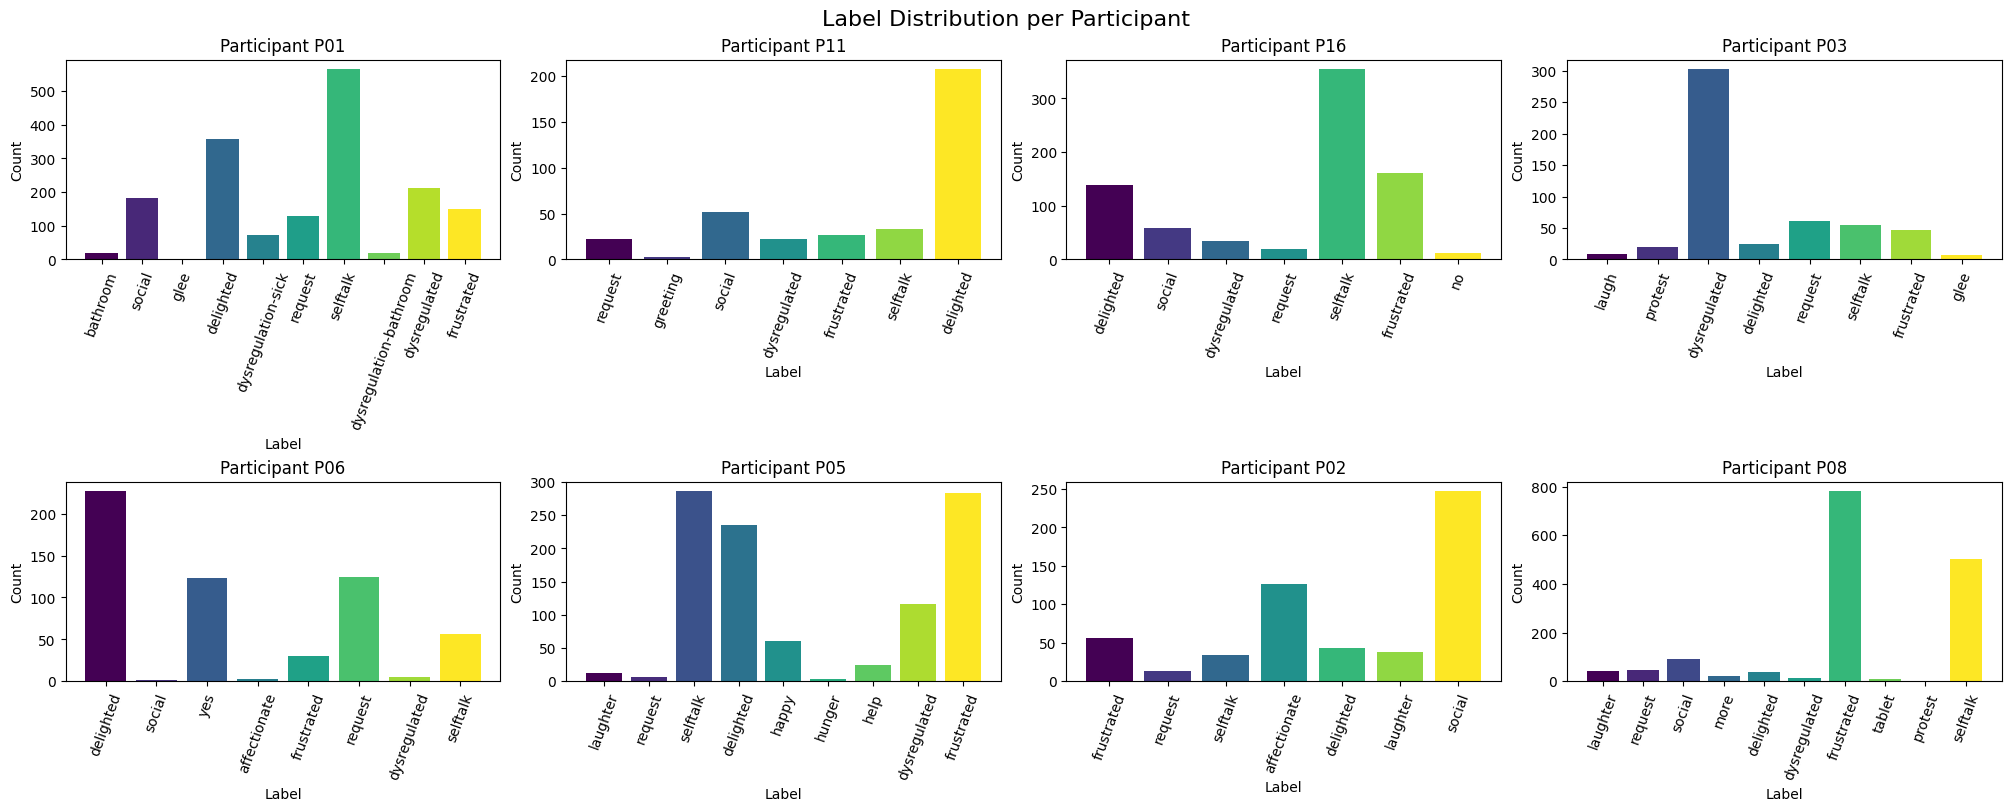

In [6]:
# Plot for each person
participant_label_counts = df.group_by(['ID', 'Label']).agg(pl.len().alias('Count'))
participant_label_counts = participant_label_counts.to_pandas()

participant_ids = participant_label_counts['ID'].unique()
n_cols = 4
n_rows = 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)
fig.suptitle('Label Distribution per Participant', fontsize=16)

for idx, participant_id in enumerate(participant_ids):
    ax = axes[idx // n_cols, idx % n_cols]  # next subplot
    data = participant_label_counts[participant_label_counts['ID'] == participant_id]
    colors = plt.cm.viridis(np.linspace(0, 1, len(data['Label'])))
    ax.bar(data['Label'], data['Count'], color=colors)
    ax.set_title(f'Participant {participant_id}')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=70)

plt.show()

In [12]:
# Make sure output directory exists
output_dir = "participant_barplots"
os.makedirs(output_dir, exist_ok=True)

# Convert Polars groupby to pandas if not already done
# participant_label_counts = df.group_by(['ID', 'Label']).agg(pl.len().alias('Count')).to_pandas()

participant_ids = participant_label_counts['ID'].unique()

for participant_id in participant_ids:
    data = participant_label_counts[participant_label_counts['ID'] == participant_id]
    
    # Generate Viridis colors
    colors = px.colors.sample_colorscale('Viridis', np.linspace(0, 1, len(data)))

    # Create interactive bar chart
    fig = px.bar(
        data,
        x='Label',
        y='Count',
        title=f'Label Distribution for Participant {participant_id}',
        color='Label',
        color_discrete_sequence=colors
    )

    fig.update_layout(
        xaxis_title='Label',
        yaxis_title='Count',
        xaxis_tickangle=70,
        margin=dict(l=40, r=40, t=60, b=100),
        plot_bgcolor='white',
        autosize=False,
        width=400,    
        height=400,
    )

    # Save each plot as HTML
    filename = os.path.join(output_dir, f"participant_{participant_id}.png")
    fig.show()
    fig.write_image(filename, width=800, height=800)
    # fig.write_html(filename)


This tells us that length of audios vary as well, very important to pad prior to training to prepare input features

In [ ]:
df = df.with_columns([
    pl.col("Audio").map_elements(lambda a: len(a), return_dtype=pl.Float64).alias("Audio Length")
])
df['Audio Length'].describe()

### Spectrograms of Unique Label Groups

This grid displays one **Mel spectrogram** for each unique vocalization label in the dataset. Each spectrogram represents a **single audio sample** randomly selected from that label group.

__Why Spectograms:__ A spectrogram is a time-frequency visualization of sound. It shows how energy (brightness) is distributed across frequency bins (y-axis) over time (x-axis). Brighter regions indicate more intensity at that frequency and time.

__Flat colors at end of some labels__: You may notice that many spectrograms appear to **suddenly turn into a solid blue color** after a certain point. This occurs because:

- All spectrograms have been **padded or cropped to a fixed width** (`target_length`), ensuring uniform input size for modeling.
- When the original audio sample is **shorter than the target time length**, the remaining time frames are filled with **zeros** — resulting in that flat, dark blue region on the right.
- This is done to make all inputs the same shape for consistent processing and modeling (e.g., embeddings or CNNs).

---

These spectrograms give an intuitive view of the **acoustic patterns** present in each vocalization type — for example:
- "YES" shows low-frequency harmonics,
- "FRUSTRATED" is noisier and denser,
- "SELF-TALK" often contains repeating patterns,
- "GLEE" and "DELIGHTED" appear more tonal or melodic.

This kind of visualization helps validate that **distinct spectral features** exist across labels, supporting downstream classification or clustering tasks.


In [10]:
def plot_unique_label_spectrograms_grid(df, n_rows=4, n_cols=6):
    unique_labels = df.select("Label").unique().to_series().to_list()
    total_plots = n_rows * n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axs = axs.flatten()
    fig.suptitle("Unique Label Spectogram", fontsize=30)

    for idx, label in enumerate(unique_labels):
        ax = axs[idx]

        # Get the first spectrogram for this label
        row = df.filter(pl.col("Label") == label).row(0)
        spectrogram = row[df.columns.index("Spectrogram")]
        spectrogram_np = np.array(spectrogram, dtype=np.float32)

        if spectrogram_np.ndim == 2:
            im = ax.imshow(spectrogram_np, aspect="auto", origin="lower", cmap="viridis")
            ax.set_title(label.upper(), fontsize=18)
            ax.set_xlabel("Time")
            ax.set_ylabel("Freq")
        else:
            ax.axis("off")

    # Hide any unused axes
    for j in range(len(unique_labels), len(axs)):
        axs[j].axis("off")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
plot_unique_label_spectrograms_grid(df)

In [16]:
def plot_unique_label_spectrograms_plotly(df, output_dir="spectrograms"):
    """
    Generate individual Plotly spectrograms for each unique label and save as HTML files.
    
    Args:
        df: Polars DataFrame containing 'Label' and 'Spectrogram' columns
        output_dir: Directory to save the HTML files (will be created if it doesn't exist)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get unique labels
    unique_labels = df.select("Label").unique().to_series().to_list()
    
    for label in unique_labels:
        # Get the first spectrogram for this label
        row = df.filter(pl.col("Label") == label).row(0)
        spectrogram = row[df.columns.index("Spectrogram")]
        spectrogram_np = np.array(spectrogram, dtype=np.float32)
        
        if spectrogram_np.ndim == 2:
            # Create a Plotly figure
            fig = go.Figure()
            
            # Add the spectrogram as a heatmap
            fig.add_trace(go.Heatmap(
                z=spectrogram_np,
                colorscale='viridis',
                showscale=True
            ))
            
            # Update layout with title and axis labels
            fig.update_layout(
                title=f"{label.upper()} Spectrogram",
                xaxis_title="Time",
                yaxis_title="Frequency",
                width=400,
                height=400
            )
            
            # Save as HTML file
            output_file = os.path.join(output_dir, f"{label.lower()}_spectrogram.html")
            fig.show()
            fig.write_html(output_file)
            print(f"Saved {output_file}")
        else:
            print(f"Skipping {label}: spectrogram is not 2-dimensional")
    
    print(f"All spectrograms saved to '{output_dir}' directory.")

In [ ]:
plot_unique_label_spectrograms_plotly(df, output_dir="spectrograms_plotly")

#### 2D Projection Setup for Audio Data Visualization

To visualize complex audio data, we extract key features, specifically Mel Frequency Cepstral Coefficients (MFCCs) and Pitch Variance, from the audio samples. These features are chosen for their ability to encapsulate the essential characteristics of sound. 

The extracted features are then subjected to dimensionality reduction techniques to project them into a 2D space, facilitating easier visualization and interpretation. The methods used for this purpose include:

- **PCA (Principal Component Analysis)**: Linear transformation technique to reduce the dimensionality while attempting to preserve as much variance as possible.
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A non-linear approach, t-SNE is effective in visualizing high-dimensional data by maintaining local relationships in a lower-dimensional space.
- **UMAP (Uniform Manifold Approximation and Projection)**: Another non-linear method that excels in preserving both local and global data structures, making it ideal for a nuanced exploration of audio features.

These projections allow us to visually analyze the clustering and distribution of audio samples, thereby providing insights into the inherent patterns and distinctions within the data.

We notice no clear clusters forming, requiring possible kernel tricks to get better seperation. 

In [ ]:
# Get pitch variance as feature for audio projection
def get_pitch_var(y: List[float], sr: int=SAMPLE_RATE):
    y_np = np.array(y, dtype=np.float64)
    f0, voiced_flag, _ = librosa.pyin(
        y_np,
        sr=sr,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7')
    )
    if f0 is None:
        return 0.0
    f0_voiced = f0[voiced_flag]
    return float(np.std(f0_voiced)) if len(f0_voiced) > 0 else 0.0

# Gets MFCC means of signal (feature for audio projection)
def get_mfcc_means(y: List[float], sr: int = 16000, n_mfcc: int = 3) -> List[float]:
    y_np = np.array(y, dtype=np.float32)
    mfccs = librosa.feature.mfcc(y=y_np, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1).tolist()  # returns [mfcc-1, mfcc-2, mfcc-3]

In [ ]:
# Extract MFCC-1, MFCC-2, MFCC-3, and Pitch variance as features for PCA
df = df.with_columns([
    pl.col("Audio").map_elements(lambda y: get_mfcc_means(y)[0], return_dtype=pl.Float64).alias("MFCC-1"),
    pl.col("Audio").map_elements(lambda y: get_mfcc_means(y)[1], return_dtype=pl.Float64).alias("MFCC-2"),
    pl.col("Audio").map_elements(lambda y: get_mfcc_means(y)[2], return_dtype=pl.Float64).alias("MFCC-3"),
    pl.col("Audio").map_elements(lambda y: get_pitch_var(y), return_dtype=pl.Float64).alias("PitchVar")
])

- **Correlations between Features**:
  - Displays varying correlation strengths between audio features.
  - Notable strong negative correlation between MFCC-1 and MFCC-3.
  - Other pairs show weak to moderate correlations.

- **2D PCA of Audio Features**:
  - Data points are broadly dispersed.
  - No clear clustering by labels, suggesting limited effectiveness of PCA in separating types.

- **UMAP Projection of Audio Features**:
  - Shows improved clustering compared to PCA.
  - Distinct groups suggest better separation of features.

- **t-SNE Projection of Audio Features**:
  - Exhibits tight clustering and clear separation between different audio labels.
  - Indicates strong capability of t-SNE in capturing local relationships in data.

### SAVE PLOTS

In [ ]:
# Features for correlation heatmap
features = ["PitchVar", "MFCC-1", "MFCC-2", "MFCC-3"]
corr = df[features].corr()

# Convert Polars DataFrame to numpy array
corr_array = corr.to_numpy()
corr_rounded = np.round(corr_array, 2)

# 1. Correlation Heatmap (Plotly)
fig_heatmap = go.Figure(data=go.Heatmap(
    z=corr_array,
    x=features,
    y=features,
    zmin=-1, zmax=1,
    colorscale='RdBu_r',
    text=corr_rounded,
    texttemplate='%{text}',
    showscale=True,
))

fig_heatmap.update_layout(
        title={
            'text': "Correlation Heatmap of Audio Features",
            'xanchor': 'left',
            'yanchor': 'top',
        },
        margin=dict(l=20, r=220, t=60, b=20),  # More right margin
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,  # Push legend further right outside the plot
            font=dict(size=12),
            itemwidth=40,  # Force horizontal space per legend item
            title='Correlations between Features'
        )
    )

fig_heatmap.show()
fig_heatmap.write_html("correlation_heatmap.html")

# Prepare MFCC data
mfccs = ["MFCC-" + str(i) for i in range(1, 4)]
X = df[mfccs].to_numpy()
labels = df["Label"].to_numpy()
unique_labels = np.unique(labels)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a distinct color map for the labels
distinct_colors = {
    label: color for label, color in zip(
        unique_labels, 
        px.colors.qualitative.D3 + px.colors.qualitative.Bold + px.colors.qualitative.Safe
    )
}

# 2. PCA (Plotly)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for Plotly
df_pca = pd.DataFrame({
    'Component 1': X_pca[:, 0],
    'Component 2': X_pca[:, 1],
    'Label': labels.astype(str)
})

fig_pca = px.scatter(
    df_pca, 
    x='Component 1', 
    y='Component 2', 
    color='Label',
    color_discrete_map=distinct_colors,
    opacity=0.7,
    title='2D PCA of Audio Features'
)

fig_pca.update_layout(
        margin=dict(l=20, r=220, t=60, b=20),  # More right margin
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,  # Push legend further right outside the plot
            font=dict(size=12),
            itemwidth=40,  # Force horizontal space per legend item
        )
    )

fig_pca.show()
fig_pca.write_html("pca_projection.html")

# 3. UMAP (Plotly)
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Create DataFrame for Plotly
df_umap = pd.DataFrame({
    'Component 1': X_umap[:, 0],
    'Component 2': X_umap[:, 1],
    'Label': labels.astype(str)
})

fig_umap = px.scatter(
    df_umap, 
    x='Component 1', 
    y='Component 2', 
    color='Label',
    color_discrete_map=distinct_colors,
    opacity=0.7,
    title='UMAP Projection of Audio Features'
)

fig_umap.update_layout(
        margin=dict(l=20, r=220, t=60, b=20),  # More right margin
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,  # Push legend further right outside the plot
            font=dict(size=12),
            itemwidth=40,  # Force horizontal space per legend item
        )
    )

fig_umap.show()
fig_umap.write_html("umap_projection.html")

# 4. t-SNE (Plotly)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create DataFrame for Plotly
df_tsne = pd.DataFrame({
    'Component 1': X_tsne[:, 0],
    'Component 2': X_tsne[:, 1],
    'Label': labels.astype(str)
})

fig_tsne = px.scatter(
    df_tsne, 
    x='Component 1', 
    y='Component 2', 
    color='Label',
    color_discrete_map=distinct_colors,
    opacity=0.7,
    title='t-SNE Projection of Audio Features'
)

fig_tsne.update_layout(
        margin=dict(l=20, r=220, t=60, b=20),  # More right margin
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,  # Push legend further right outside the plot
            font=dict(size=12),
            itemwidth=40,  # Force horizontal space per legend item
        )
    )

fig_tsne.show()
fig_tsne.write_html("tsne_projection.html")


In [2]:
df = pickle.load(open("processed_data.pkl", "rb"))

In [ ]:
features = ["PitchVar", "MFCC-1", "MFCC-2", "MFCC-3"]

# Prepare MFCC data
mfccs = ["MFCC-" + str(i) for i in range(1, 4)]
X = df[mfccs].to_numpy()
labels = df["Label"].to_numpy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a distinct color map for the labels
unique_labels = np.unique(labels)
# Distinct color palette - high contrast colors that are visually distinguishable
distinct_colors = {
    # Vibrant, distinct colors that work well for visualization
    label: color for label, color in zip(
        unique_labels, 
        px.colors.qualitative.D3 + px.colors.qualitative.Bold + px.colors.qualitative.Safe
    )
}

# Helper to make 3D plot and save HTML with distinct colors
def save_3d_plot(X_3d, labels, title, filename):
    # Create a dataframe for plotly
    import pandas as pd
    plot_df = pd.DataFrame({
        'x': X_3d[:, 0],
        'y': X_3d[:, 1],
        'z': X_3d[:, 2],
        'Label': labels.astype(str)
    })
    
    fig = px.scatter_3d(
        plot_df,
        x='x', y='y', z='z',
        color='Label',
        color_discrete_map=distinct_colors,  # Apply the custom color mapping
        title=title,
        labels={"x": "Component 1", "y": "Component 2", "z": "Component 3"},
        opacity=0.7
    )
    
    fig.update_layout(
        margin=dict(l=20, r=220, t=60, b=20),  # More right margin
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,  # Push legend further right outside the plot
            font=dict(size=12),
            itemwidth=40,  # Force horizontal space per legend item
        )
    )
    fig.show()
    fig.write_html(f"../checkpoint3/website/clarity/images/{filename}")

# 2. PCA (3D)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
save_3d_plot(X_pca, labels, "3D PCA of Audio Features", "pca_3d.html")

# 3. UMAP (3D)
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
save_3d_plot(X_umap, labels, "3D UMAP Projection of Audio Features", "umap_3d.html")

# 4. t-SNE (3D)
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
save_3d_plot(X_tsne, labels, "3D t-SNE Projection of Audio Features", "tsne_3d.html")

In [ ]:
# Selecting MFCCs and Pitch variance as features for 2d projection 
features = ["PitchVar", "MFCC-1", "MFCC-2", "MFCC-3"]
corr = df[features].corr()

# Correlation matrix
plt.figure(figsize=(16, 16))  
plt.subplot(221)

# Heat map
sns.heatmap(data=corr, annot=True, cmap="coolwarm", xticklabels=features, yticklabels=features)
plt.title("Correlations between Features")

# Prepare data for PCA, UMAP, and t-SNE
mfccs = ["MFCC-" + str(i) for i in range(1, 4)]
X = df[mfccs].to_numpy()
labels = df["Label"].to_numpy()

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot PCA
plt.subplot(222)
unique_labels = np.unique(labels)
for label in unique_labels:
    idx = labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of Audio Features")
plt.legend(loc="best", fontsize="small")
plt.grid(True)

# Plot UMAP
plt.subplot(223)
for label in unique_labels:
    idx = labels == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=label, alpha=0.6)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Projection of Audio Features")
plt.legend(loc="best", fontsize="small")
plt.grid(True)

# Plot t-SNE
plt.subplot(224)
for label in unique_labels:
    idx = labels == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, alpha=0.6)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection of Audio Features")
plt.legend(loc="best", fontsize="small")
plt.grid(True)

plt.tight_layout()
plt.show()

## Feature Extraction & Hypothesis Testing

In this section, we extract acoustic features from vocalizations and statistically evaluate whether they differ significantly across expression labels. These tests aim to determine if vocal cues such as **pitch variability**, and **spectral shape** (MFCCs) carry meaningful information that can distinguish between intents like `"yes"` and `"no"`.

---

### Tests Conducted:
1. **Pitch Variability** – Mann-Whitney U test on pitch standard deviation across samples.
2. **MFCC Differences** – Mann-Whitney U test on mean MFCC coefficients (1–3).
3. **Spectral Entropy Differences** - ANOVA + Ad-Hoc Pairwise T tests on Spectral Entropy.

---

### Results:

Our statistical tests revealed **significant acoustic differences** between `"yes"` and `"no"` vocalizations:

- **Pitch Variability**:
  - "No" vocalizations showed **much higher pitch variability** (std = 119.13) compared to "Yes" (std = 22.46).
  - Mann-Whitney U test confirmed this with **p < 0.001** and a large effect size (**Cohen’s d = -2.38**).

- **MFCCs (Spectral Shape)**:
  - Significant differences were found in **MFCC-1** and **MFCC-3** (both **p < 0.001**, Cohen’s d > 1.6), indicating strong differences in **spectral slope** and **fine spectral variation**.
  - **MFCC-2** showed **no significant difference**, suggesting similar mid-frequency emphasis in both groups.

- **Spectral Entropy**:
  - Significant differences in spectral entropy were found between various vocalization labels, indicating that certain emotional states could be distinguished based on their spectral characteristics.
  - Strong entropy differences were notably present between "dysregulated" and "delighted", and between "selftalk" and "frustrated", highlighting that spectral entropy can be a useful feature in distinguishing emotional states in vocalizations.


These findings suggest that both **pitch dynamics** and **spectral shape** are promising features for distinguishing vocal intent in non-verbal utterances for the model development phase.


## Hypothesis Testing

### Test 1: Pitch Variability Differences between "Yes" and "No" Vocalizations (Mann-Whitney U Test)

This test evaluates whether there are statistically significant differences in **pitch variability** between vocalizations labeled as `"yes"` and `"no"`. Pitch variability is measured as the **standard deviation of estimated pitch (f₀)** across time for each audio sample. This metric reflects how much the speaker's pitch varies within a vocalization type, often tied to emotional expressiveness or vocal intent.

#### What is Pitch Variability?

- Calculated using **Librosa's PYIN algorithm**, which estimates fundamental frequency (f₀) for voiced segments of an audio signal.
- We then compute the **standard deviation** of those f₀ values per sample.
- A **higher pitch std** generally means more variation in tone, while a lower std suggests more monotonic vocalization.

#### Test Setup

- **Statistic**: Mann-Whitney U test (non-parametric)
- **Effect Size**: Cohen’s *d*
- **Input Feature**: Standard deviation of pitch per sample
- **Groups Compared**: `"yes"` vs `"no"` vocalizations
- **Sample Size**: 100 samples for "yes", 12 samples for "no"
- **Alpha**: Will use a significance level of 0.05 

---

### Null Hypothesis (H₀):
- There is **no difference** in pitch variability between vocalizations labeled as "yes" and "no". The distributions of pitch standard deviation are the same for both groups.

### Alternative Hypothesis (H₁):
- There is a **difference** in pitch variability between vocalizations labeled as "yes" and "no". The distributions of pitch standard deviation are not the same for both groups, indicating that one group may exhibit more pitch variation than the other.


#### Group Means & Standard Deviations

| Label      | Pitch Std (Mean ± Std) |
|------------|------------------------|
| **Yes**    | 19.818 ± 20.91          |
| **No**     | 114.964 ± 110.339        |

#### Statistical Results Summary

| Metric             | Value                         |
|--------------------|-------------------------------|
| **U Statistic**     | 260.0                         |
| **p-value**         | 0.001                       |
| **Cohen’s d**       | -2.370                         |
| **Mean Difference** | -95.147                        |
| **Significant**     |   Yes                         |

### Interpretation:

Since our p = 0.01 < alpha, we __reject__ the null hypothesis. We interpret that:

- The **"no"** vocalizations exhibit **dramatically higher pitch variability** than "yes" samples — almost **5× higher on average**.
- The test yields a **low p-value (0.01)** and a **large negative effect size (Cohen’s d = -2.38)**, indicating a strong and statistically significant difference.
- This suggests that **pitch dynamics** could be a powerful feature in differentiating certain types of vocal intent, especially when classifying expressive vs. flat responses.


In [12]:
def batch_pitch_extraction(audio_list: List,
                           max_samples_per_batch: int=50,
                           sr: int=SAMPLE_RATE) -> List[float]:
    # Randomly sample if batch is too large
    if len(audio_list) > max_samples_per_batch:
        sample_indices = np.random.choice(len(audio_list), max_samples_per_batch, replace=False)
        audio_list = [audio_list[i] for i in sample_indices]
    
    pitch_stds = []
    for audio_array in audio_list:
        audio_array = np.asarray(audio_array, dtype=np.float64)
        
        # Extract pitch using PYIN
        f0, voiced_flag, _ = librosa.pyin(
            audio_array, 
            fmin=librosa.note_to_hz('C2'),
            fmax=librosa.note_to_hz('C7'),
            sr=sr
        )
        
        # Filter for voiced segments
        f0_voiced = f0[voiced_flag]
        
        # Calculate pitch std, handle empty case
        pitch_std = float(np.std(f0_voiced)) if len(f0_voiced) > 0 else 0.0
        pitch_stds.append(pitch_std)
    
    return pitch_stds

def pitch_variability_test(df: pl.DataFrame,
                           max_batch_size: int=50,
                           target_labels: List[str]=['frustrated', 'delighted']) -> Dict[str, float]:
    # Group audio by label
    label_audio_groups = {}
    for label in target_labels:
        # Extract audio for each label
        label_audio_groups[label] = df.filter(pl.col("Label") == label)["Audio"].to_list()
    
    # Batch pitch extraction
    label_pitch_stds = {}
    for label, audio_list in label_audio_groups.items():
        label_pitch_stds[label] = batch_pitch_extraction(audio_list=audio_list, max_samples_per_batch=max_batch_size)
        
        # Print basic stats
        pitch_array = np.array(label_pitch_stds[label])
        print(f"{label} samples: {len(pitch_array)}")
        print(f"  Mean pitch std: {np.mean(pitch_array):.4f}")
        print(f"  Std of pitch std: {np.std(pitch_array):.4f}")
    
    # Perform statistical tests
    label1_data = label_pitch_stds[target_labels[0]]
    label2_data = label_pitch_stds[target_labels[1]]
    
    # Mann-Whitney U Test
    u_statistic, p_value = scipy.stats.mannwhitneyu(
        label1_data, 
        label2_data, 
        alternative='two-sided'
    )
    
    # Effect size calculation (Cohen's d)
    mean1, std1 = np.mean(label1_data), np.std(label1_data)
    mean2, std2 = np.mean(label2_data), np.std(label2_data)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((len(label1_data) - 1) * std1**2 + 
                          (len(label2_data) - 1) * std2**2) / 
                         (len(label1_data) + len(label2_data) - 2))
    
    # Cohen's d
    cohens_d = (mean1 - mean2) / pooled_std
    
    # Prepare results
    results = {
        'Mann-Whitney U Statistic': u_statistic,
        'p-value': p_value,
        'Cohen\'s d': cohens_d,
        'Mean Difference': mean1 - mean2,
        'Significant': p_value < 0.05
    }
    
    # Print results
    print("\n=== Hypothesis Test Results ===")
    for key, value in results.items():
        print(f"{key}: {value}")
    
    return results

In [13]:
# Spectogram plotting functions to compare labels 
def plot_spectrogram_comparison(df, label1="yes", label2="no", sr=SAMPLE_RATE, n_examples=2):
    fig, axes = plt.subplots(n_examples, 2, figsize=(12, 4 * n_examples))
    label_map = {0: label1, 1: label2}

    for i, label in enumerate([label1, label2]):
        examples = df.filter(pl.col("Label") == label).head(n_examples).iter_rows(named=True)
        for j, row in enumerate(examples):
            y = np.array(row["Audio"])
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_db = librosa.power_to_db(S, ref=np.max)
            ax = axes[j, i] if n_examples > 1 else axes[i]
            librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
            ax.set_title(f"{label_map[i].upper()} Sample #{j+1}")
            ax.set_xlabel("")
            ax.set_ylabel("")

    plt.suptitle("Mel Spectrogram Comparison: YES vs NO", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
t0 = time.time()
results = pitch_variability_test(df=df, max_batch_size=100, target_labels=["yes", "no"])
print(f"\n🎶 Pitch Variability Test completed in {time.time() - t0:.2f} seconds")

- **"YES" Samples**: Show varied frequency patterns with bright spots indicating dynamic changes in pitch.
- **"NO" Samples**: Display consistent and flat energy patterns with fewer changes.

In [ ]:
plot_spectrogram_comparison(df, label1="yes", label2="no", sr=SAMPLE_RATE, n_examples=4)

In [43]:
def plot_plotly_spectrogram_comparison(df, label1="yes", label2="no", sr=SAMPLE_RATE, n_examples=4, output_dir="comparison_spectrograms"):
    """
    Generate side-by-side Plotly spectrograms comparing 'yes' and 'no' labels and save as HTML files.
    
    Args:
        df: Polars DataFrame containing 'Label' and 'Audio' columns
        label1: First label to compare (default: "yes")
        label2: Second label to compare (default: "no")
        sr: Sample rate (default: 16000)
        n_examples: Number of examples to plot (default: 4)
        output_dir: Directory to save the HTML files (will be created if it doesn't exist)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get examples for each label
    label1_examples = df.filter(pl.col("Label") == label1).head(n_examples).to_pandas()
    label2_examples = df.filter(pl.col("Label") == label2).head(n_examples).to_pandas()
    
    # Create a separate HTML file for each pair of examples
    for j in range(n_examples):
        if j < len(label1_examples) and j < len(label2_examples):
            # Create subplot figure with 1 row and 2 columns
            fig = make_subplots(
                rows=1, cols=2,
                subplot_titles=(f"{label1.upper()} Sample #{j+1}", f"{label2.upper()} Sample #{j+1}")
            )
            
            # Process first label example
            y1 = np.array(label1_examples.iloc[j]["Audio"])
            S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128)
            S_db1 = librosa.power_to_db(S1, ref=np.max)
            
            # Process second label example
            y2 = np.array(label2_examples.iloc[j]["Audio"])
            S2 = librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=128)
            S_db2 = librosa.power_to_db(S2, ref=np.max)
            
            # Add spectrograms as heatmaps
            fig.add_trace(
                go.Heatmap(
                    z=S_db1,
                    colorscale='viridis',
                    colorbar=dict(title="dB", x=0.46),
                    name=label1.upper()
                ),
                row=1, col=1
            )
            
            fig.add_trace(
                go.Heatmap(
                    z=S_db2,
                    colorscale='viridis',
                    colorbar=dict(title="dB", x=1.0),
                    name=label2.upper()
                ),
                row=1, col=2
            )
            
            # Update layout
            fig.update_layout(
                title_text=f"Mel Spectrogram Comparison: {label1.upper()} vs {label2.upper()} (Sample #{j+1})",
                height=600,
                width=1800
            )
            
            # Update axes
            fig.update_xaxes(title_text="Time", row=1, col=1)
            fig.update_xaxes(title_text="Time", row=1, col=2)
            fig.update_yaxes(title_text="Mel Frequency", row=1, col=1)
            
            # Save as HTML file
            output_file = os.path.join(output_dir, f"comparison_{label1}_vs_{label2}_sample{j+1}.html")
            fig.show()
            fig.write_html(output_file)
            print(f"Saved {output_file}")
    
    print(f"All comparison spectrograms saved to '{output_dir}' directory.")

In [ ]:
plot_plotly_spectrogram_comparison(df, label1="yes", label2="no", sr=SAMPLE_RATE, n_examples=4)

### Test 2: Mel Frequency Cepstral Coefficients (MFCCs) Mean Differences between "Yes" and "No" Vocalizations (Pairwise Mann-Whitney U Test)

This test evaluates whether there are statistically significant differences in **spectral shape** between the vocalizations labeled as `"yes"` and `"no"`, focusing on the **mean values of the first three MFCCs**.

#### What are MFCCs?

- **MFCC-1**: Captures the overall **spectral slope** — indicates the energy balance between low and high frequencies.
- **MFCC-2**: Captures the **curvature** of the spectral envelope — flat vs. peaked energy in the mid frequencies.
- **MFCC-3**: Represents **fine-grained variation** — subtle changes or "ripples" in the spectral shape.
- Higher-order MFCCs (4, 5, …) capture increasingly localized detail and high-frequency texture.

---

#### Test Setup

- **Statistic**: Pairwise Mann-Whitney U test, a non-parametric test used to compare differences between two independent groups when the data cannot be assumed to be normally distributed.
- **Effect Size**: Cohen’s *d*
- **Input Features**: Mean of MFCC-1, MFCC-2, and MFCC-3 per sample
- **Groups Compared**: `"yes"` vs `"no"` vocalizations
- **Alpha**: We will use a significance level of 0.05

---

### Null Hypothesis (H₀):
- There are **no significant differences** in the mean values of the first three MFCCs (MFCC-1, MFCC-2, and MFCC-3) between vocalizations labeled as "yes" and "no". The distributions of these spectral shape measures are the same across both groups.

### Alternative Hypothesis (H₁):
- There are **significant differences** in the mean values of the first three MFCCs (MFCC-1, MFCC-2, and MFCC-3) between vocalizations labeled as "yes" and "no". The distributions of these spectral shape measures vary between the two groups, indicating discriminative spectral characteristics.

#### Results

__Group Means & Standard Deviations__

| Label | MFCC-1 Mean ± Std | MFCC-2 Mean ± Std | MFCC-3 Mean ± Std |
|-------|-------------------|-------------------|-------------------|
| **Yes** | -323.365 ± 32.903 | 122.607 ± 18.428 | -16.314 ± 15.998 |
| **No**  | -262.130 ± 42.377 | 114.124 ± 25.801 | -52.627 ± 27.668 |

__Statistical Results Summary__

| MFCC      | U Statistic | p-value        | Cohen’s *d* | Mean Diff | Significant |
|-----------|-------------|----------------|-------------|-----------|-------------|
| **MFCC-1** | 158.0       | 3.277e-05      | -1.803      | -61.235   | Yes         |
| **MFCC-2** | 708.0       | 0.312          | 0.440       | 8.483     | No          |
| **MFCC-3** | 1048.0      | 2.557e-05      | 2.073       | 36.312    | Yes         |

### Interpretation:

Since our p value for MFCC-1 (p = 3.277e-05) and MFCC-3 (p = 2.557e-05) are below alpha = 0.05, we reject the null hypothesis for MFCC-1 and MFCC-3. This indicates there are signficant differences between spectral slope and fine-grain variation between different labels, aiding in discerning label groups and serving as important features. 

- **MFCC-1** and **MFCC-3** show statistically significant differences between "yes" and "no" samples, with Cohen’s *d* indicating large effect sizes, which suggests these features are powerful discriminators.
- **MFCC-2** does not show a statistically significant difference, suggesting it might not carry as much discriminative power between these two vocalization types.
- The results lead to the rejection of the null hypothesis for MFCC-1 and MFCC-3, confirming significant differences in spectral shape that could be instrumental in classifying or clustering intent in non-verbal vocalizations.
- These results indicate that **low and mid-frequency spectral properties** (slope and variation) carry meaningful differences between vocalizations, while overall mid-frequency curvature does not.

In [ ]:
def batch_mfcc_extraction(audio_list: List,
                          max_samples_per_batch: int=50,
                          sr: int=SAMPLE_RATE,
                          n_coeffs: int=3) -> List[float]:
    if len(audio_list) > max_samples_per_batch:
        sample_indices = np.random.choice(len(audio_list), max_samples_per_batch, replace=False)
        audio_list = [audio_list[i] for i in sample_indices]
    
    mfcc_means = []
    for audio_array in audio_list:
        audio_array = np.asarray(audio_array, dtype=np.float32)
        mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_coeffs)
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_means.append(mfcc_mean)
    
    return mfcc_means

def mfcc_significance_test(df, max_batch_size=50, target_labels=["frustrated", "delighted"], n_coeffs=3):
    label_audio_groups = {}
    for label in target_labels:
        label_audio_groups[label] = df.filter(pl.col("Label") == label)["Audio"].to_list()
    
    label_mfcc_means = {}
    for label, audio_list in label_audio_groups.items():
        label_mfcc_means[label] = batch_mfcc_extraction(
            audio_list,
            max_samples_per_batch=max_batch_size,
            n_coeffs=n_coeffs,
            sr=SAMPLE_RATE
        )
        mfcc_array = np.array(label_mfcc_means[label])
        print(f"{label} samples: {len(mfcc_array)}")
        
        for i in range(n_coeffs):
            print(f"  MFCC-{i+1} Mean: {np.mean(mfcc_array[:, i]):.4f}, Std: {np.std(mfcc_array[:, i]):.4f}")

    results = {}
    for i in range(n_coeffs):
        data1 = [x[i] for x in label_mfcc_means[target_labels[0]]]
        data2 = [x[i] for x in label_mfcc_means[target_labels[1]]]

        u_statistic, p_value = scipy.stats.mannwhitneyu(data1, data2, alternative='two-sided')
        mean1, std1 = np.mean(data1), np.std(data1)
        mean2, std2 = np.mean(data2), np.std(data2)

        pooled_std = np.sqrt(((len(data1) - 1) * std1**2 + (len(data2) - 1) * std2**2) /
                             (len(data1) + len(data2) - 2))
        cohens_d = (mean1 - mean2) / pooled_std

        results[f"MFCC-{i+1}"] = {
            'U Statistic': u_statistic,
            'p-value': p_value,
            'Cohen\'s d': cohens_d,
            'Mean Difference': mean1 - mean2,
            'Significant': p_value < 0.05
        }

    print("\n=== MFCC Significance Test Results ===")
    for k, v in results.items():
        print(f"\n{k}")
        for stat, val in v.items():
            print(f"  {stat}: {val}")
    
    return results


In [29]:
def box_and_heat_mfcc_comparison(df, labels=["yes", "no"], sr=22050, n_mfcc=3):
    # Step 1: Prepare data
    data = []
    mfcc_data = {label: [] for label in labels}

    for label in labels:
        for row in df.filter(pl.col("Label") == label).iter_rows(named=True):
            y = np.array(row["Audio"])
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfccs, axis=1)

            # For boxplot
            for i in range(n_mfcc):
                data.append({
                    "MFCC": f"MFCC-{i+1}",
                    "Value": float(mfcc_mean[i]),
                    "Label": label
                })

            # For heatmap
            mfcc_data[label].append(mfcc_mean)

    # Convert to pandas DataFrame for Plotly
    df_plot = pd.DataFrame(data)

    # Prepare heatmap data
    heat_data = []
    for label in labels:
        means = np.mean(np.stack(mfcc_data[label]), axis=0)
        row = [float(means[i]) for i in range(n_mfcc)]
        heat_data.append(row)

    # Color mapping
    colors = px.colors.qualitative.D3[:len(labels)]
    color_dict = {label: color for label, color in zip(labels, colors)}

    # Step 2: Create Boxplot Figure
    box_fig = go.Figure()
    for label in labels:
        label_data = df_plot[df_plot["Label"] == label]
        box_fig.add_trace(
            go.Box(
                x=label_data["MFCC"],
                y=label_data["Value"],
                name=label,
                marker_color=color_dict[label],
                boxmean=True
            )
        )
    box_fig.update_layout(
        title="MFCC Distribution (Boxplot)",
        xaxis_title="MFCC Coefficient",
        yaxis_title="Value",
        boxmode='group',
        margin=dict(l=20, r=220, t=60, b=20),  # More right margin
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,  # Push legend further right outside the plot
            font=dict(size=12),
            itemwidth=40,  # Force horizontal space per legend item
        ),
        width=800,
        height=600
    )

    # Step 3: Create Heatmap Figure
    heatmap_fig = go.Figure(
        go.Heatmap(
            z=heat_data,
            x=[f"MFCC-{i+1}" for i in range(n_mfcc)],
            y=[label.upper() for label in labels],
            colorscale='Viridis',
            text=[[f"{val:.1f}" for val in row] for row in heat_data],
            texttemplate="%{text}",
            colorbar=dict(title="Value")
        )
    )
    heatmap_fig.update_layout(
        title="MFCC Mean Comparison (Heatmap)",
        xaxis_title="MFCC Coefficient",
        yaxis_title="Label",
        margin=dict(l=20, r=220, t=60, b=20),  # More right margin
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,  # Push legend further right outside the plot
            font=dict(size=12),
            itemwidth=40,  # Force horizontal space per legend item
        ),
        width=800,
        height=600
    )

    box_fig.show()
    box_fig.write_html("mfcc_boxplot.html")
    heatmap_fig.show()
    heatmap_fig.write_html("mfcc_heatmap.html")


In [ ]:
t0 = time.time()
results = mfcc_significance_test(df, max_batch_size=100, target_labels=["yes", "no"], n_coeffs=3)
print(f"\n🎛️ MFCC Significance Test completed in {time.time() - t0:.2f} seconds")

The visual representations show the distribution and mean comparisons of the first three MFCCs for vocalizations labeled "Yes" and "No". The boxplot illustrates variability within each MFCC across the two vocalization types, while the heatmap provides a direct comparison of their mean values (easier for the eye to notice the notable differences).

In [30]:
box_and_heat_mfcc_comparison(df, labels=["yes", "no"], n_mfcc=3)

### Test 3: Spectral Entropy Differences Across Vocalization Labels (ANOVA & T-Tests)

This analysis investigates whether there are statistically significant differences in **spectral entropy** between different vocalization labels (`"dysregulated"`, `"hunger"`, `"delighted"`).


#### What is Spectral Entropy?

Spectral entropy measures the **disorder** or **randomness** in an audio signal's frequency distribution. A higher entropy indicates a more uniform spectral distribution, while lower entropy suggests a more structured or tonal signal.

---

#### Test Setup

- **Statistic**: One-way ANOVA & Pairwise T-tests
- **Effect Size**: Cohen’s *d* (for pairwise comparisons)
- **Input Feature**: Spectral entropy computed from short-time Fourier transform (STFT)
- **Groups Compared**: `"dysregulated"`, `"hunger"`, `"delighted"`
- **Sample Size**: Maximum of 100 samples per label

---

### Null Hypothesis (H₀):
- There are **no significant differences** in spectral entropy among the vocalization labels `"dysregulated"`, `"hunger"`, and `"delighted"`. All groups exhibit similar entropy distributions.

### Alternative Hypothesis (H₁):
- There are **significant differences** in spectral entropy among the vocalization labels `"dysregulated"`, `"hunger"`, and `"delighted"`. At least one of these groups exhibits a different entropy distribution compared to the others.

#### Results

__ANOVA Results__

| Test | F-Statistic | p-value | Significant |
|------|------------|---------|-------------|
| **Spectral Entropy** | 22.914 | 1.067e-13 | Yes |

A significant ANOVA result suggests that at least one group has a different spectral entropy distribution.

---

#### Pairwise T-Test Summary

| Comparison                 | T-Statistic | p-value      | Significant |
|----------------------------|-------------|--------------|-------------|
| **Dysregulated vs Selftalk** | -15.48      | 5.76e-50      | Yes         |
| **Dysregulated vs Delighted** | -11.94      | 1.19e-31      | Yes         |
| **Dysregulated vs Frustrated** | -2.10       | 0.036         | No          |
| **Selftalk vs Delighted**     | +1.65       | 0.100         | No          |
| **Selftalk vs Frustrated**    | +14.18      | 3.37e-44      | Yes         |
| **Delighted vs Frustrated**   | +10.49      | 3.05e-25      | Yes         |


---

### Interpretation

- **Strong differences** in spectral entropy are observed between:
  - `"dysregulated"` and both `"selftalk"` & `"delighted"`
  - `"selftalk"` and `"frustrated"`
  - `"delighted"` and `"frustrated"`

- No significant difference between:
  - `"dysregulated"` and `"frustrated"`
  - `"selftalk"` and `"delighted"`

These results suggest that **spectral entropy can effectively differentiate between some vocal states**, particularly those on emotional extremes. However, overlaps exist, indicating entropy may not capture all acoustic nuance across labels.

Given the significant results from the ANOVA (p = 1.067e-13) and most pairwise T-tests, we **reject the null hypothesis**. This indicates there are significant differences in spectral entropy among the vocalization labels tested.


In [ ]:
def compute_spectral_entropy(y):
    # Compute power spectral density
    S = np.abs(librosa.stft(y))**2
    
    # Normalize each frame to create a probability distribution
    S_norm = S / (np.sum(S, axis=0) + 1e-10)
    
    # Compute Shannon entropy using log base 2 (information-theoretic interpretation)
    spectral_entropy = -np.sum(S_norm * np.log2(S_norm + 1e-10), axis=0)
    
    # Normalize by maximum possible entropy for the given frequency bins
    max_entropy = np.log2(S.shape[0])  # log2(n_bins)
    normalized_entropy = spectral_entropy / max_entropy
    
    return float(np.mean(normalized_entropy))

def spectral_entropy_anova_test(df, target_labels=["dysregulated", "hunger", "delighted"], max_samples_per_label=50):
    """Perform ANOVA on spectral entropy differences."""
    label_audio_groups = {label: df.filter(pl.col("Label") == label)["Audio"].to_list() for label in target_labels}
    label_entropy_means = {label: [compute_spectral_entropy(np.array(y)) for y in audio_list[:max_samples_per_label]]
                            for label, audio_list in label_audio_groups.items()}
    data = [label_entropy_means[label] for label in target_labels]

    # One-way ANOVA test
    f_statistic, p_value = scipy.stats.f_oneway(*data)

    results = {
        'ANOVA F-Statistic': f_statistic,
        'p-value': p_value,
        'Significant': p_value < 0.05
    }

    print("\n=== Spectral Entropy ANOVA Test Results ===")
    for key, value in results.items():
        print(f"{key}: {value}")

    return results


target_labels = ["dysregulated", "selftalk", "delighted", "frustrated"]
t0 = time.time()
results = spectral_entropy_anova_test(df, target_labels=target_labels, max_samples_per_label=100)
print(f"\nSpectral Entropy ANOVA Test completed in {time.time() - t0:.2f} seconds")

__Must run ad-hoc tests to test which pairings are significantly different__

In [49]:
def pairwise_t_test(df, target_labels, feature="Spectral Entropy"):
    label_data = {label: df.filter(pl.col("Label") == label)[feature].to_list() for label in target_labels}

    results = {}
    alpha = 0.05 / (len(target_labels) * (len(target_labels) - 1) / 2)

    for l1, l2 in list(combinations(target_labels, 2)):
            data1, data2 = label_data[l1], label_data[l2]

            t_statistic, p_value = scipy.stats.ttest_ind(data1, data2, equal_var=False)

            results[f"{l1} vs {l2}"] = {
                "T-Statistic": t_statistic,
                "P-Value": p_value,
                "Significant": p_value < alpha
            }

    return results

def format_t_test_results(results_dict):
    df_results = pd.DataFrame.from_dict(results_dict, orient="index")
    df_results.rename(columns={"T-Statistic": "T-Statistic", "P-Value": "P-Value", "Significant": "Significant"}, inplace=True)
    
    # Apply scientific notation for small p-values
    df_results["P-Value"] = df_results["P-Value"].apply(lambda x: f"{x:.15e}" if x < 1e-5 else f"{x:.15f}")

    print("\n=== Pairwise T-Test Results ===\n")
    print(df_results.to_string(index=True))

def plot_spectral_entropy_comparison(df, target_labels, feature="Spectral Entropy"):
    """Generate a boxplot for spectral entropy distributions across groups."""
    data = [(label, value) for label in target_labels for value in df.filter(pl.col("Label") == label)[feature].to_list()]
    df_plot = pd.DataFrame(data, columns=["Label", feature])


    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Label", y=feature, data=df_plot, hue="Label", palette="Set2", legend=False)
    plt.title("Spectral Entropy Comparison Across Labels")
    plt.ylabel("Spectral Entropy")
    plt.xlabel("Label")
    plt.grid(True)
    plt.show()

In [ ]:
# Calculate spectral entropy for t test
df = df.with_columns([
    pl.col("Audio").map_elements(lambda y: compute_spectral_entropy(np.array(y)), return_dtype=pl.Float64).alias("Spectral Entropy")
])

In [ ]:
labels = df["Label"].unique()
t_test_results = pairwise_t_test(df, target_labels=target_labels, feature="Spectral Entropy")
format_t_test_results(t_test_results)
plot_spectral_entropy_comparison(df, target_labels=target_labels)